In [1]:
import torch
from torch import nn
from torchvision.models import vgg19_bn
from torch.nn import functional as F
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Models

### VAE-123

using relu_1 relu_2, relu_3

In [3]:
### Creating deep feature consistnent VAE class

class DFCVAE_123(nn.Module):
  def __init__(self, input_dim, output_dim: int, alpha:float = 1, beta:float = 0.5, **kwargs):
      super(DFCVAE_123, self).__init__()

      self.input_dim = input_dim
      self.output_dim = output_dim
      self.alpha = alpha
      self.beta = beta
      # using pretrained model as the paper
      self.feature_cnn = vgg19_bn(pretrained=True)
      # freezing parameters of trained VGG19 models so they won't change through out the run.
      for param in self.feature_cnn.parameters():
            param.requires_grad = False
      self.feature_cnn.eval()

      # building 4 convulution layers for the encoder as explained in paper:
      # kernel is 4X4, stripe fixed to 2.
      # followed by batch normalizetion and leaky Relu activation function.
      self.encoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.Conv2d(self.input_dim, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.Conv2d(32, out_channels=64, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.Conv2d(64, out_channels=128, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.Conv2d(128, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
      )

      self.mean = nn.Linear(64*64, self.output_dim)
      self.variance = nn.Linear(64*64, self.output_dim)
      self.decoder_input = nn.Linear(self.output_dim, 64*64)

      # building 4 convulution layers for the decoder as explained in paper:
      # kernel is 3X3, stripe fixed to 1.
      # followed by replication layer batch normalizetion and leaky Relu activation function.
      self.decoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.ConvTranspose2d(256, out_channels=128, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.ConvTranspose2d(128, out_channels=64, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.ConvTranspose2d(64, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.ConvTranspose2d(32, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
                    nn.Conv2d(32, out_channels= 3,
                              kernel_size= 3, padding= 1)
      )

  def forward(self, input: torch.tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      mean = self.mean(result)
      variance = self.variance(result)

      # reparameterizition trick rom N(mean, variance) to N(0,1).
      z = torch.randn_like(torch.exp(0.5 * variance))*torch.exp(0.5 * variance)+mean

      reconstracted = self.decoder_input(z)
      reconstracted = reconstracted.view(-1, 256, 4, 4)
      reconstracted = self.decoder(reconstracted)
      #removing edges added in replication layers
      reconstracted = reconstracted[:,:,30:94,30:94]

      # extracting features from layers in VGG19 pretrained model for input image and reconstracted image
      feature_layers = ['2', '5', '9']
      input_features = []
      reconstracted_features = []
      input_result = input
      rec_result = reconstracted
      for (key, module) in self.feature_cnn.features._modules.items():
            input_result = module(input_result)
            rec_result = module(rec_result)
            if(key in feature_layers):
                input_features.append(input_result)
                reconstracted_features.append(rec_result)

      return input, reconstracted, input_features, reconstracted_features, mean, variance

  def loss_function(self, input, reconstracted, input_features, reconstracted_features, mean, variance):
      feature_perceptual_loss = 0.0
      for (r, i) in zip(reconstracted_features, input_features):
          feature_perceptual_loss += F.mse_loss(r, i)

      # this is the kld used when we assume normal distibutions 
      kld_loss = torch.mean(-0.5 * torch.sum(1 + variance - mean ** 2 - variance.exp(), dim = 1), dim = 0)

      loss = self.alpha * kld_loss*0.001 + self.beta * (F.mse_loss(reconstracted, input) + feature_perceptual_loss)

      return loss, {'loss': loss, 'Reconstruction_Loss':feature_perceptual_loss, 'KLD':-kld_loss}


### VAE-345

using relu_3 relu_4, relu_5

In [4]:
### Creating deep feature consistnent VAE class

class DFCVAE_345(nn.Module):
  def __init__(self, input_dim, output_dim: int, alpha:float = 1, beta:float = 0.5, **kwargs):
      super(DFCVAE_345, self).__init__()

      self.input_dim = input_dim
      self.output_dim = output_dim
      self.alpha = alpha
      self.beta = beta
      # using pretrained model as the paper
      self.feature_cnn = vgg19_bn(pretrained=True)
      # freezing parameters of trained VGG19 models so they won't change through out the run.
      for param in self.feature_cnn.parameters():
            param.requires_grad = False
      self.feature_cnn.eval()

      # building 4 convulution layers for the encoder as explained in paper:
      # kernel is 4X4, stripe fixed to 2.
      # followed by batch normalizetion and leaky Relu activation function.
      self.encoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.Conv2d(self.input_dim, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.Conv2d(32, out_channels=64, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.Conv2d(64, out_channels=128, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.Conv2d(128, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
      )

      self.mean = nn.Linear(64*64, self.output_dim)
      self.variance = nn.Linear(64*64, self.output_dim)
      self.decoder_input = nn.Linear(self.output_dim, 64*64)

      # building 4 convulution layers for the decoder as explained in paper:
      # kernel is 3X3, stripe fixed to 1.
      # followed by replication layer batch normalizetion and leaky Relu activation function.
      self.decoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.ConvTranspose2d(256, out_channels=128, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.ConvTranspose2d(128, out_channels=64, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.ConvTranspose2d(64, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.ConvTranspose2d(32, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
                    nn.Conv2d(32, out_channels= 3,
                              kernel_size= 3, padding= 1)
      )

  def forward(self, input: torch.tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      mean = self.mean(result)
      variance = self.variance(result)

      # reparameterizition trick rom N(mean, variance) to N(0,1).
      z = torch.randn_like(torch.exp(0.5 * variance))*torch.exp(0.5 * variance)+mean

      reconstracted = self.decoder_input(z)
      reconstracted = reconstracted.view(-1, 256, 4, 4)
      reconstracted = self.decoder(reconstracted)
      #removing edges added in replication layers
      reconstracted = reconstracted[:,:,30:94,30:94]

      # extracting features from layers in VGG19 pretrained model for input image and reconstracted image
      feature_layers = ['9', '12', '16']
      input_features = []
      reconstracted_features = []
      input_result = input
      rec_result = reconstracted
      for (key, module) in self.feature_cnn.features._modules.items():
            input_result = module(input_result)
            rec_result = module(rec_result)
            if(key in feature_layers):
                input_features.append(input_result)
                reconstracted_features.append(rec_result)

      return input, reconstracted, input_features, reconstracted_features, mean, variance

  def loss_function(self, input, reconstracted, input_features, reconstracted_features, mean, variance):
      feature_perceptual_loss = 0.0
      for (r, i) in zip(reconstracted_features, input_features):
          feature_perceptual_loss += F.mse_loss(r, i)

      # this is the kld used when we assume normal distibutions 
      kld_loss = torch.mean(-0.5 * torch.sum(1 + variance - mean ** 2 - variance.exp(), dim = 1), dim = 0)

      loss = self.alpha * kld_loss*0.001 + self.beta * (F.mse_loss(reconstracted, input) + feature_perceptual_loss)

      return loss, {'loss': loss, 'Reconstruction_Loss':feature_perceptual_loss, 'KLD':-kld_loss}



### VAE-all
using all hidden layers in pre-trained VGG19 to calculate the perceptual loss

In [5]:
### Creating deep feature consistnent VAE class

class DFCVAE_all(nn.Module):
  def __init__(self, input_dim, output_dim: int, alpha:float = 1, beta:float = 0.5, **kwargs):
      super(DFCVAE_all, self).__init__()

      self.input_dim = input_dim
      self.output_dim = output_dim
      self.alpha = alpha
      self.beta = beta
      # using pretrained model as the paper
      self.feature_cnn = vgg19_bn(pretrained=True)
      # freezing parameters of trained VGG19 models so they won't change through out the run.
      for param in self.feature_cnn.parameters():
            param.requires_grad = False
      self.feature_cnn.eval()

      # building 4 convulution layers for the encoder as explained in paper:
      # kernel is 4X4, stripe fixed to 2.
      # followed by batch normalizetion and leaky Relu activation function.
      self.encoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.Conv2d(self.input_dim, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.Conv2d(32, out_channels=64, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.Conv2d(64, out_channels=128, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.Conv2d(128, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
      )

      self.mean = nn.Linear(64*64, self.output_dim)
      self.variance = nn.Linear(64*64, self.output_dim)
      self.decoder_input = nn.Linear(self.output_dim, 64*64)

      # building 4 convulution layers for the decoder as explained in paper:
      # kernel is 3X3, stripe fixed to 1.
      # followed by replication layer batch normalizetion and leaky Relu activation function.
      self.decoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.ConvTranspose2d(256, out_channels=128, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.ConvTranspose2d(128, out_channels=64, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.ConvTranspose2d(64, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.ConvTranspose2d(32, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
                    nn.Conv2d(32, out_channels= 3,
                              kernel_size= 3, padding= 1)
      )

  def forward(self, input: torch.tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      mean = self.mean(result)
      variance = self.variance(result)

      # reparameterizition trick rom N(mean, variance) to N(0,1).
      z = torch.randn_like(torch.exp(0.5 * variance))*torch.exp(0.5 * variance)+mean

      reconstracted = self.decoder_input(z)
      reconstracted = reconstracted.view(-1, 256, 4, 4) 
      reconstracted = self.decoder(reconstracted)
      #removing edges added in replication layers
      reconstracted = reconstracted[:,:,30:94,30:94]

      # extracting features from layers in VGG19 pretrained model for input image and reconstracted image
      input_features = []
      reconstracted_features = []
      input_result = input
      rec_result = reconstracted
      for (key, module) in self.feature_cnn.features._modules.items():
            input_result = module(input_result)
            rec_result = module(rec_result)
            input_features.append(input_result)
            reconstracted_features.append(rec_result)

      return input, reconstracted, input_features, reconstracted_features, mean, variance

  def loss_function(self, input, reconstracted, input_features, reconstracted_features, mean, variance):
      feature_perceptual_loss = 0.0
      for (r, i) in zip(reconstracted_features, input_features):
          feature_perceptual_loss += F.mse_loss(r, i)

      # this is the kld used when we assume normal distibutions 
      kld_loss = torch.mean(-0.5 * torch.sum(1 + variance - mean ** 2 - variance.exp(), dim = 1), dim = 0)

      loss = self.alpha * kld_loss*0.001 + self.beta * (F.mse_loss(reconstracted, input) + feature_perceptual_loss)

      return loss, {'loss': loss, 'Reconstruction_Loss':feature_perceptual_loss, 'KLD':-kld_loss}



### Plain VAE


In [6]:
### Plain VAE using simple binary cross entropy loss

class VAE_plain(nn.Module):
  def __init__(self, input_dim, output_dim: int, alpha:float = 1, beta:float = 0.5, **kwargs):
      super(VAE_plain, self).__init__()

      self.input_dim = input_dim
      self.output_dim = output_dim
      self.alpha = alpha
      self.beta = beta

      # building 4 convulution layers for the encoder as explained in paper:
      # kernel is 4X4, stripe fixed to 2.
      # followed by batch normalizetion and leaky Relu activation function.
      self.encoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.Conv2d(self.input_dim, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.Conv2d(32, out_channels=64, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.Conv2d(64, out_channels=128, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.Conv2d(128, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
      )

      self.mean = nn.Linear(64*64, self.output_dim)
      self.variance = nn.Linear(64*64, self.output_dim)
      self.decoder_input = nn.Linear(self.output_dim, 64*64)

      # building 4 convulution layers for the decoder as explained in paper:
      # kernel is 3X3, stripe fixed to 1.
      # followed by replication layer batch normalizetion and leaky Relu activation function.
      self.decoder = nn.Sequential(
          # first convulution layer
          nn.Sequential(nn.ConvTranspose2d(256, out_channels=128, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU()),
          # second convulution layer
          nn.Sequential(nn.ConvTranspose2d(128, out_channels=64, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU()),
          # third convulution layer
          nn.Sequential(nn.ConvTranspose2d(64, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
          # fourth convulution layer
          nn.Sequential(nn.ConvTranspose2d(32, out_channels=32, kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.ReplicationPad2d(2),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU()),
                    nn.Conv2d(32, out_channels= 3,
                              kernel_size= 3, padding= 1)
      )

  def forward(self, input):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      mean = self.mean(result)
      variance = self.variance(result)

      # reparameterizition trick rom N(mean, variance) to N(0,1).
      z = torch.randn_like(torch.exp(0.5 * variance))*torch.exp(0.5 * variance)+mean

      reconstracted = self.decoder_input(z)
      reconstracted = reconstracted.view(-1, 256, 4, 4)
      reconstracted = self.decoder(reconstracted)
      #removing edges added in replication layers
      reconstracted = reconstracted[:,:,30:94,30:94]

      return input, reconstracted, mean, variance
  
  def recons_loss(self, x_hat, logscale, x):
      scale = torch.exp(logscale)
      mean = x_hat
      dist = torch.distributions.Normal(mean, scale)

      # measure prob of seeing image under p(x|z)
      log_pxz = dist.log_prob(x)
      return
  
  def loss_function(self, input, reconstracted, mean, variance):

      # this is the kld used when we assume normal distibutions 
      kld_loss = torch.mean(-0.5 * torch.sum(1 + variance - mean ** 2 - variance.exp(), dim = 1), dim = 0)

      recon_loss = F.mse_loss(reconstracted, input)
      loss = recon_loss  + 0.001*kld_loss
      return loss , {'loss': loss, 'reconstructed loss':recon_loss , 'KLD':-kld_loss}





# Running Data

In [7]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

## Comic faces (paired, synthetic) Data

In [ ]:
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/face_2.zip

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder('/content/face_2', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
# training VAE-123 model
print('training VAE-123')
model_123 = DFCVAE_123(3, 128).to(device)
opt = torch.optim.Adam(model_123.parameters(), lr = 0.0005)

for epoch in range(15):
    for images, _ in train_dl:
        images = images.to(device) # GPU
        opt.zero_grad()
        input, reconstracted, input_features, reconstracted_features, mean, variance = model_123.forward(images)
        loss, loss_info = model_123.loss_function(input, reconstracted, input_features, reconstracted_features, mean, variance)
        loss.backward()
        opt.step()
    print(f'for epoch {epoch}, recieved loss of {loss_info}')


training VAE-123


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


for epoch 0, recieved loss of {'loss': tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-3.9053, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 1, recieved loss of {'loss': tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-10.4829, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 2, recieved loss of {'loss': tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-12.2403, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 3, recieved loss of {'loss': tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-13.9066, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 4, recieved loss of {'l

In [11]:
# training VAE-345 model
print('training VAE-345')
model_345 = DFCVAE_345(3, 128).to(device)
opt = torch.optim.Adam(model_345.parameters(), lr = 0.0005)
for epoch in range(15):
    for images, _ in train_dl:
        images = images.to(device) # GPU
        opt.zero_grad()
        input, reconstracted, input_features, reconstracted_features, mean, variance = model_345.forward(images)
        loss, loss_info = model_345.loss_function(input, reconstracted, input_features, reconstracted_features, mean, variance)
        loss.backward()
        opt.step()
    print(f'for epoch {epoch}, recieved loss of {loss_info}')



training VAE-345


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


for epoch 0, recieved loss of {'loss': tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-10.0734, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 1, recieved loss of {'loss': tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-11.9882, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 2, recieved loss of {'loss': tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-12.3107, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 3, recieved loss of {'loss': tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-12.4323, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 4, recieved loss of {'

In [12]:
# training VAE-All
print('training VAE-All')
model_all = DFCVAE_all(3, 128).to(device)
opt = torch.optim.Adam(model_all.parameters(), lr = 0.0005)
for epoch in range(15):
    for images, _ in train_dl:
        images = images.to(device) # GPU
        opt.zero_grad()
        input, reconstracted, input_features, reconstracted_features, mean, variance = model_all.forward(images)
        loss, loss_info = model_all.loss_function(input, reconstracted, input_features, reconstracted_features, mean, variance)
        loss.backward()
        opt.step()
    print(f'for epoch {epoch}, recieved loss of {loss_info}')

training VAE-All


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


for epoch 0, recieved loss of {'loss': tensor(0.7863, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.3602, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-23.1959, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 1, recieved loss of {'loss': tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.3586, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-21.9026, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 2, recieved loss of {'loss': tensor(0.6926, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.1937, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-31.5953, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 3, recieved loss of {'loss': tensor(0.6309, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0826, device='cuda:0', grad_fn=<AddBackward0>), 'KLD': tensor(-42.7938, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 4, recieved loss of {'

In [13]:
# training Plain VAE model 
print('training plain VAE')
model_plain = VAE_plain(3, 128).to(device)
opt = torch.optim.Adam(model_plain.parameters(), lr = 0.0005)
for epoch in range(15):
    for images, _ in train_dl:
        images = images.to(device) # GPU
        opt.zero_grad()
        input, reconstracted, mean, variance = model_plain.forward(images)
        loss, loss_info = model_plain.loss_function(input, reconstracted, mean, variance)
        loss.backward()
        opt.step()
    print(f'for epoch {epoch}, recieved loss of {loss_info}')

training plain VAE


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


for epoch 0, recieved loss of {'loss': tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>), 'reconstructed loss': tensor(0.1059, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-22.1411, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 1, recieved loss of {'loss': tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>), 'reconstructed loss': tensor(0.0888, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-16.0473, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 2, recieved loss of {'loss': tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>), 'reconstructed loss': tensor(0.0720, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-19.0968, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 3, recieved loss of {'loss': tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>), 'reconstructed loss': tensor(0.0792, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(-18.3710, device='cuda:0', grad_fn=<NegBackward0>)}
for epoch 4, recieve

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


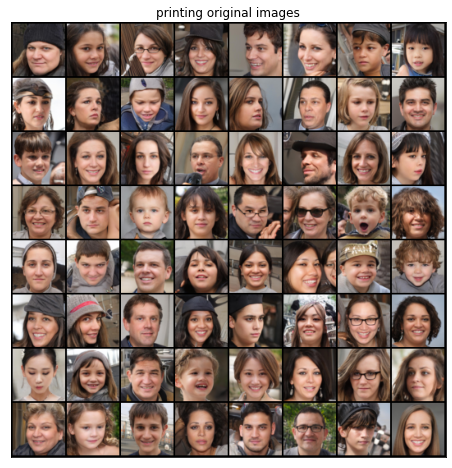

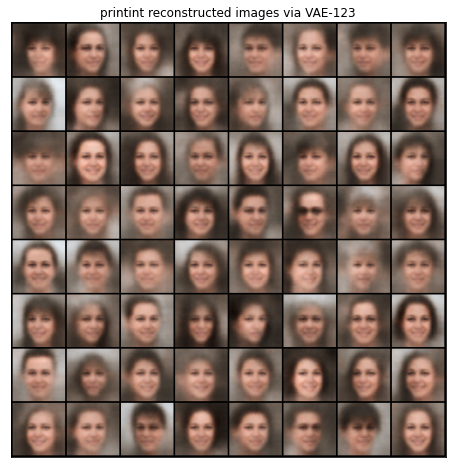

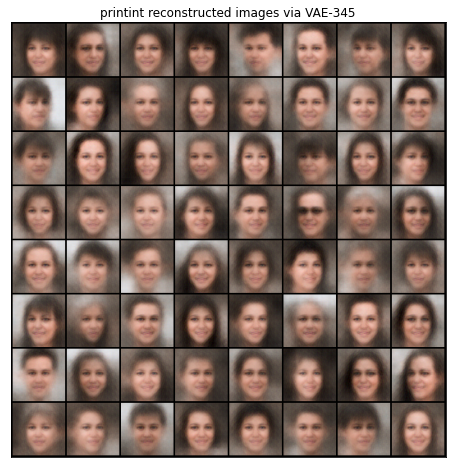

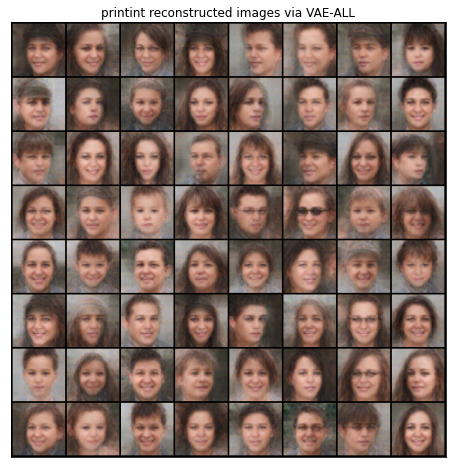

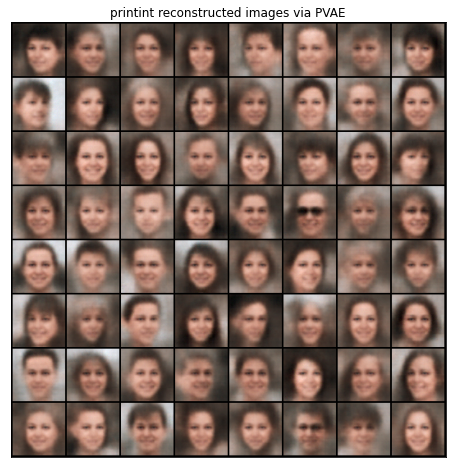

In [14]:
for images,_ in train_dl:
  print_img = images
  break
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('printing original images')
ax.imshow(make_grid(denorm(print_img.detach()[:64]), nrow=8).permute(1, 2, 0))
print_img = print_img.to(device)

input, reconstracted, input_features, reconstracted_features, mean, variance = model_123.forward(print_img)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('printing reconstructed images via VAE-123')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

input, reconstracted, input_features, reconstracted_features, mean, variance = model_345.forward(print_img)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('printing reconstructed images via VAE-345')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

input, reconstracted, input_features, reconstracted_features, mean, variance = model_all.forward(print_img)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('printing reconstructed images via VAE-ALL')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

input, reconstracted, mean, variance = model_plain.forward(print_img)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('printing reconstructed images via PVAE')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

### Ganerate experiment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


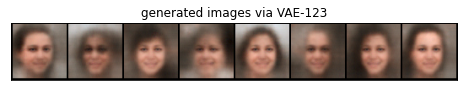

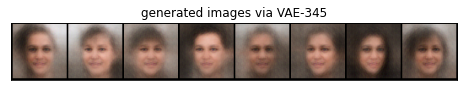

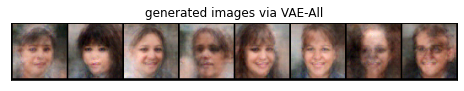

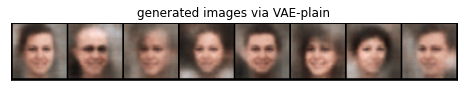

In [25]:
# random vector to generate 4 different images.
z = torch.randn((8,128))
z = z.to(device)

# pass random vectors through the decoder of VAE-123
reconstracted = model_123.decoder_input(z)
reconstracted = reconstracted.view(-1, 256, 4, 4)
reconstracted = model_123.decoder(reconstracted)
reconstracted = reconstracted[:,:,30:94,30:94]

# plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('generated images via VAE-123')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

# pass random vectors through the decoder of VAE-345
reconstracted = model_345.decoder_input(z)
reconstracted = reconstracted.view(-1, 256, 4, 4) 
reconstracted = model_345.decoder(reconstracted)
reconstracted = reconstracted[:,:,30:94,30:94]

# plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('generated images via VAE-345')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))


# pass random vectors through the decoder of VAE-All
reconstracted = model_all.decoder_input(z)
reconstracted = reconstracted.view(-1, 256, 4, 4)
reconstracted = model_all.decoder(reconstracted)
reconstracted = reconstracted[:,:,30:94,30:94]

# plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('generated images via VAE-All')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))

# pass random vectors through the decoder of VAE-Plain
reconstracted = model_plain.decoder_input(z)
reconstracted = reconstracted.view(-1, 256, 4, 4) 
reconstracted = model_plain.decoder(reconstracted)
reconstracted = reconstracted[:,:,30:94,30:94]

# plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.title.set_text('generated images via VAE-plain')
reconstracted = reconstracted.cpu()
ax.imshow(make_grid(denorm(reconstracted.detach()[:64]), nrow=8).permute(1, 2, 0))